test for rest

In [1]:
import os
os.getcwd()
import sys
sys.path.append('/mnt/c/Users/domin/github/kinope')


In [2]:
import kinope

In [3]:
import importlib
importlib.reload(kinope)

<module 'kinope' from '/mnt/c/Users/domin/github/kinope/kinope/__init__.py'>

In [30]:
from openmmtools.testsystems import AlanineDipeptideExplicit

In [31]:
ala = AlanineDipeptideVacuum()

In [33]:
ala.system.getForces()
ala.system.removeForce(4)

In [34]:
ala.system.getForces()

[<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7f6cfa492a20> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7f6cfa492900> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x7f6cfa492c60> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f6cfa492ab0> >]

In [35]:
from kinope.tempering import RESTFactory

In [36]:
factory = RESTFactory(ala.system, solute_region=[0,1,2,3,4])

INFO:temper:No MonteCarloBarostat added.
INFO:temper:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:temper:No unknown forces.


In [37]:
out_sys = factory.REST_system

In [38]:
out_sys.getForces()

[<simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x7f6cfa4920c0> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x7f6cfa492330> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x7f6cfa4921b0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f6cfa492810> >]

In [12]:
from openmmtools.states import ThermodynamicState, SamplerState
from simtk import unit
og_thermostate = ThermodynamicState(ala.system, temperature=300*unit.kelvin)
new_thermostate = ThermodynamicState(out_sys, temperature=300*unit.kelvin)
samplerstate = SamplerState(ala.positions)

In [13]:
from openmmtools.integrators import DummyIntegrator
ble1_int, bleh2_int = DummyIntegrator(), DummyIntegrator()

In [14]:
og_context = og_thermostate.create_context(ble1_int)

In [15]:
new_context = new_thermostate.create_context(bleh2_int)

In [16]:
samplerstate.apply_to_context(og_context)
samplerstate.apply_to_context(new_context)

In [17]:
og_state = og_context.getState(getEnergy=True)
new_state = new_context.getState(getEnergy=True)

In [18]:
og_state.getPotentialEnergy()

Quantity(value=-88.08855399792417, unit=kilojoule/mole)

In [19]:
new_state.getPotentialEnergy()

Quantity(value=-88.08855399792404, unit=kilojoule/mole)

great, now i should be able to get the protocol...

In [20]:
protocol = factory.get_protocol(300, 1200)

In [21]:
for key, val in protocol.items():
    print(key, val)
    print()

solute_scale 300 / select(step(lambda - 0.5), 300 + (1200 - 300)*(exp(2*(1.0 - lambda)) - 1) / (exp(1) - 1), 300 + (1200 - 300)*(exp(2*(lambda)) - 1) / (exp(1) - 1))

inter_scale sqrt(300 / select(step(lambda - 0.5), 300 + (1200 - 300)*(exp(2*(1.0 - lambda)) - 1) / (exp(1) - 1), 300 + (1200 - 300)*(exp(2*(lambda)) - 1) / (exp(1) - 1)))

steric_scale (300 / select(step(lambda - 0.5), 300 + (1200 - 300)*(exp(2*(1.0 - lambda)) - 1) / (exp(1) - 1), 300 + (1200 - 300)*(exp(2*(lambda)) - 1) / (exp(1) - 1))) - 1

electrostatic_scale sqrt(300 / select(step(lambda - 0.5), 300 + (1200 - 300)*(exp(2*(1.0 - lambda)) - 1) / (exp(1) - 1), 300 + (1200 - 300)*(exp(2*(lambda)) - 1) / (exp(1) - 1))) - 1



get the periodicneqintegrator.

In [22]:
from openmmtools.integrators import PeriodicNonequilibriumIntegrator

In [23]:
nsteps_eq = 1 # number of steps to dwell in equilibrium at lambda = 0 or 1
nsteps_neq = 10 # number of steps in the switching trajectory where lambda is switched from 0 to 1

In [24]:
neq_integrator = PeriodicNonequilibriumIntegrator(
    temperature=300*unit.kelvin, collision_rate=1.0/unit.picoseconds, timestep=4.0*unit.femtoseconds,
    alchemical_functions=protocol, splitting="V R H O R V",
    nsteps_eq=nsteps_eq, nsteps_neq=nsteps_neq)

In [25]:
from simtk import openmm as openmm
context = openmm.Context(out_sys, neq_integrator)

In [26]:
context.setPositions(samplerstate.positions)

In [27]:
nsteps_per_period = 2*nsteps_eq + 2*nsteps_neq
#neq_integrator.step(nsteps_per_period)

In [28]:
state = context.getState(getParameters=True)
p = state.getParameters()
for x in p:
    print(x, p[x])

electrostatic_scale 0.0
inter_scale 1.0
solute_scale 1.0
steric_scale 0.0


In [29]:
for i in range(nsteps_per_period):
    neq_integrator.step(1)
    state = context.getState(getParameters=True)
    p = state.getParameters()
    for x in p:
        print(x, p[x])
    print()

electrostatic_scale 0.0
inter_scale 1.0
solute_scale 1.0
steric_scale 0.0

electrostatic_scale -0.15075764490412935
inter_scale 0.8492423550958706
solute_scale 0.7212125776887809
steric_scale -0.2787874223112191

electrostatic_scale -0.2665063856803106
inter_scale 0.7334936143196894
solute_scale 0.5380128822477612
steric_scale -0.4619871177522388

electrostatic_scale -0.35920629089601197
inter_scale 0.640793709103988
solute_scale 0.41061657762724646
steric_scale -0.5893834223727535

electrostatic_scale -0.43564118431100607
inter_scale 0.5643588156889939
solute_scale 0.31850087284588385
steric_scale -0.6814991271541162

electrostatic_scale -0.5
inter_scale 0.5
solute_scale 0.25
steric_scale -0.75

electrostatic_scale -0.43564118431100607
inter_scale 0.5643588156889939
solute_scale 0.31850087284588385
steric_scale -0.6814991271541162

electrostatic_scale -0.35920629089601197
inter_scale 0.640793709103988
solute_scale 0.41061657762724646
steric_scale -0.5893834223727535

electrostatic_sca

In [38]:
import numpy as np
lambdas = np.linspace(0,1,10)

T_min, T_max=300, 1200
yielder = lambda x: np.where(x < 0.5, T_min + (T_max-T_min)*(np.exp(2*x) - 1) / (np.exp(1) - 1), T_min + (T_max-T_min)*(np.exp(2*(1-x)) - 1) / (np.exp(1) - 1))

In [39]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


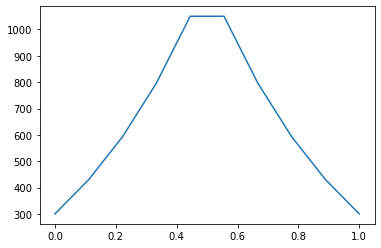

In [40]:
plt.plot(lambdas, yielder(lambdas))

In [41]:
yielder(lambdas)

array([ 300.        ,  430.34182076,  593.1190562 ,  796.40322258,
       1050.27442385, 1050.27442385,  796.40322258,  593.1190562 ,
        430.34182076,  300.        ])